# 훈련 30만 테스트 4.5만 에포크 100 러닝레이트 0.01

In [1]:
# 필요한 라이브러리 임포트
import os
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shutil
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from tqdm import tqdm
import time

# 이미지 조정(전처리) - 텐서화, 정규화, 크기 조정

In [3]:
# 전처리 작업을 정의
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# GPU 사용가능 여부 판단

In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU')
else:
    device = torch.device("cpu")
    print('CPU')

GPU


# 데이터 로더

In [6]:
from torchvision import transforms, datasets
import torchvision
import torchvision
from torchvision import transforms

In [7]:
# train 데이터셋 생성
trainset = torchvision.datasets.ImageFolder(
    root="C://Users//User//Desktop//capstone//수리방법//수리방법 학습",
    transform = train_transforms)

# 훈련 데이터 로드
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

In [8]:
# test 데이터셋 생성
testset = torchvision.datasets.ImageFolder(
    root="C://Users//User//Desktop//capstone//수리방법//수리방법 테스트",
    transform = test_transforms)

# 테스트 데이터 로드
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# 모델 로드

In [9]:
# ResNet-50 모델 로드
model = models.resnet50(pretrained=True)

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 레이어 수정 및 손실 함수, 옵티마이저 설정

In [10]:
# 모델의 FC 레이어 수정
num_classes = len(trainset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# 손실 함수 및 옵티마이저 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    for phase in ['train']:
        if phase == 'train':
            model.train()
            
        corrects = 0
        total = 0
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch}/{num_epochs}', unit='batch'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            total += labels.size(0)
            running_loss += loss.item()
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / total
        epoch_acc = corrects / total

        print(f'훈련 정확도: {epoch_acc:.4f} Loss: {epoch_loss:.4f}')
    
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
    
        # 평가 모드로 설정
        model.eval()

        # 평가를 위한 변수 초기화
        corrects = 0
        total = 0
        test_loss = 0.0

        # tqdm으로 래핑하여 진행 상황 표시
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, total=len(testloader)):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        # 정확도 계산
        accuracy = corrects / total

        # 평가 손실 계산
        test_loss /= len(testloader.dataset)

        print(f"테스트 정확도: {accuracy:.4f} loss: {test_loss:.4f}")
    
        test_losses.append(test_loss)
        test_acc.append(accuracy)

print("Training complete")

Epoch 0/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.04batch/s]


훈련 정확도: 0.6323 Loss: 0.0247


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:14<00:00,  2.87it/s]


테스트 정확도: 0.6479 loss: 0.0250


Epoch 1/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.23batch/s]


훈련 정확도: 0.6894 Loss: 0.0216


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7757 loss: 0.0186


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [15:05<00:00, 10.10batch/s]


훈련 정확도: 0.7190 Loss: 0.0199


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:56<00:00,  2.98it/s]


테스트 정확도: 0.7531 loss: 0.0202


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [14:40<00:00, 10.39batch/s]


훈련 정확도: 0.7344 Loss: 0.0189


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.8008 loss: 0.0172


Epoch 4/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [15:00<00:00, 10.16batch/s]


훈련 정확도: 0.7478 Loss: 0.0181


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7840 loss: 0.0182


Epoch 5/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [15:16<00:00,  9.98batch/s]


훈련 정확도: 0.7569 Loss: 0.0175


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:54<00:00,  2.99it/s]


테스트 정확도: 0.7359 loss: 0.0200


Epoch 6/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [14:55<00:00, 10.22batch/s]


훈련 정확도: 0.7661 Loss: 0.0169


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7783 loss: 0.0182


Epoch 7/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [15:04<00:00, 10.11batch/s]


훈련 정확도: 0.7745 Loss: 0.0163


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:56<00:00,  2.98it/s]


테스트 정확도: 0.7837 loss: 0.0183


Epoch 8/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [14:52<00:00, 10.25batch/s]


훈련 정확도: 0.7813 Loss: 0.0159


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:53<00:00,  3.01it/s]


테스트 정확도: 0.7455 loss: 0.0201


Epoch 9/100: 100%|██████████████████████████████████████████████████████████████| 9148/9148 [14:59<00:00, 10.18batch/s]


훈련 정확도: 0.7874 Loss: 0.0155


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7871 loss: 0.0177


Epoch 10/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:01<00:00, 10.15batch/s]


훈련 정확도: 0.7942 Loss: 0.0150


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:54<00:00,  3.00it/s]


테스트 정확도: 0.7781 loss: 0.0183


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:06<00:00, 10.10batch/s]


훈련 정확도: 0.7975 Loss: 0.0147


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:54<00:00,  3.00it/s]


테스트 정확도: 0.7882 loss: 0.0177


Epoch 12/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:02<00:00, 10.14batch/s]


훈련 정확도: 0.8037 Loss: 0.0144


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:56<00:00,  2.99it/s]


테스트 정확도: 0.8026 loss: 0.0170


Epoch 13/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:04<00:00, 10.11batch/s]


훈련 정확도: 0.8084 Loss: 0.0140


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7972 loss: 0.0173


Epoch 14/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:56<00:00, 10.21batch/s]


훈련 정확도: 0.8129 Loss: 0.0137


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.96it/s]


테스트 정확도: 0.7782 loss: 0.0186


Epoch 15/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:03<00:00, 10.13batch/s]


훈련 정확도: 0.8177 Loss: 0.0134


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:56<00:00,  2.99it/s]


테스트 정확도: 0.7907 loss: 0.0181


Epoch 16/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.8206 Loss: 0.0131


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:52<00:00,  3.01it/s]


테스트 정확도: 0.7858 loss: 0.0185


Epoch 17/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.22batch/s]


훈련 정확도: 0.8253 Loss: 0.0128


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.96it/s]


테스트 정확도: 0.7654 loss: 0.0198


Epoch 18/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:07<00:00, 10.08batch/s]


훈련 정확도: 0.8280 Loss: 0.0127


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7740 loss: 0.0192


Epoch 19/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:08<00:00, 10.07batch/s]


훈련 정확도: 0.8324 Loss: 0.0124


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7935 loss: 0.0180


Epoch 20/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:21<00:00,  9.93batch/s]


훈련 정확도: 0.8359 Loss: 0.0121


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.96it/s]


테스트 정확도: 0.7649 loss: 0.0201


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:25<00:00,  9.88batch/s]


훈련 정확도: 0.8388 Loss: 0.0119


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.97it/s]


테스트 정확도: 0.7826 loss: 0.0191


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.8426 Loss: 0.0117


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:56<00:00,  2.99it/s]


테스트 정확도: 0.8092 loss: 0.0179


Epoch 23/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.05batch/s]


훈련 정확도: 0.8445 Loss: 0.0115


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7692 loss: 0.0197


Epoch 24/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.05batch/s]


훈련 정확도: 0.8473 Loss: 0.0113


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7942 loss: 0.0184


Epoch 25/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.02batch/s]


훈련 정확도: 0.8512 Loss: 0.0111


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7667 loss: 0.0206


Epoch 26/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:24<00:00,  9.90batch/s]


훈련 정확도: 0.8546 Loss: 0.0109


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7846 loss: 0.0192


Epoch 27/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:19<00:00,  9.95batch/s]


훈련 정확도: 0.8557 Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7963 loss: 0.0194


Epoch 28/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:23<00:00,  9.91batch/s]


훈련 정확도: 0.8597 Loss: 0.0105


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.93it/s]


테스트 정확도: 0.7649 loss: 0.0213


Epoch 29/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:06<00:00, 10.09batch/s]


훈련 정확도: 0.8614 Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.92it/s]


테스트 정확도: 0.7386 loss: 0.0220


Epoch 30/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:23<00:00,  9.90batch/s]


훈련 정확도: 0.8636 Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.92it/s]


테스트 정확도: 0.7786 loss: 0.0207


Epoch 31/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:52<00:00, 10.25batch/s]


훈련 정확도: 0.8663 Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.92it/s]


테스트 정확도: 0.7254 loss: 0.0238


Epoch 32/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:53<00:00, 10.24batch/s]


훈련 정확도: 0.8679 Loss: 0.0099


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.93it/s]


테스트 정확도: 0.7935 loss: 0.0197


Epoch 33/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:57<00:00, 10.19batch/s]


훈련 정확도: 0.8704 Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7765 loss: 0.0208


Epoch 34/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.04batch/s]


훈련 정확도: 0.8731 Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7546 loss: 0.0230


Epoch 35/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:02<00:00, 10.13batch/s]


훈련 정확도: 0.8753 Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7728 loss: 0.0217


Epoch 36/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:14<00:00, 10.00batch/s]


훈련 정확도: 0.8769 Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7582 loss: 0.0230


Epoch 37/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:20<00:00,  9.94batch/s]


훈련 정확도: 0.8797 Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7836 loss: 0.0212


Epoch 38/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:18<00:00,  9.96batch/s]


훈련 정확도: 0.8810 Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7754 loss: 0.0217


Epoch 39/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:19<00:00,  9.95batch/s]


훈련 정확도: 0.8826 Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.97it/s]


테스트 정확도: 0.7666 loss: 0.0219


Epoch 40/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:19<00:00,  9.95batch/s]


훈련 정확도: 0.8842 Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.97it/s]


테스트 정확도: 0.7715 loss: 0.0226


Epoch 41/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.03batch/s]


훈련 정확도: 0.8863 Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7771 loss: 0.0223


Epoch 42/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.02batch/s]


훈련 정확도: 0.8884 Loss: 0.0085


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7687 loss: 0.0233


Epoch 43/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:14<00:00, 10.00batch/s]


훈련 정확도: 0.8899 Loss: 0.0083


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7727 loss: 0.0232


Epoch 44/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:22<00:00,  9.92batch/s]


훈련 정확도: 0.8922 Loss: 0.0082


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.97it/s]


테스트 정확도: 0.7740 loss: 0.0232


Epoch 45/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:06<00:00, 10.09batch/s]


훈련 정확도: 0.8926 Loss: 0.0082


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7786 loss: 0.0230


Epoch 46/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.02batch/s]


훈련 정확도: 0.8955 Loss: 0.0080


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.93it/s]


테스트 정확도: 0.7461 loss: 0.0258


Epoch 47/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:23<00:00,  9.90batch/s]


훈련 정확도: 0.8974 Loss: 0.0079


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7909 loss: 0.0227


Epoch 48/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.02batch/s]


훈련 정확도: 0.8981 Loss: 0.0078


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.93it/s]


테스트 정확도: 0.7958 loss: 0.0230


Epoch 49/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:19<00:00,  9.95batch/s]


훈련 정확도: 0.8989 Loss: 0.0077


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7482 loss: 0.0265


Epoch 50/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.02batch/s]


훈련 정확도: 0.9010 Loss: 0.0076


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7754 loss: 0.0250


Epoch 51/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9020 Loss: 0.0075


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7252 loss: 0.0287


Epoch 52/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.05batch/s]


훈련 정확도: 0.9027 Loss: 0.0074


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7798 loss: 0.0232


Epoch 53/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:22<00:00,  9.92batch/s]


훈련 정확도: 0.9053 Loss: 0.0073


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.96it/s]


테스트 정확도: 0.7581 loss: 0.0250


Epoch 54/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:18<00:00,  9.96batch/s]


훈련 정확도: 0.9065 Loss: 0.0072


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7822 loss: 0.0248


Epoch 55/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9075 Loss: 0.0071


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7001 loss: 0.0305


Epoch 56/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:18<00:00,  9.96batch/s]


훈련 정확도: 0.9093 Loss: 0.0070


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7567 loss: 0.0278


Epoch 57/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:10<00:00, 10.05batch/s]


훈련 정확도: 0.9092 Loss: 0.0070


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7656 loss: 0.0262


Epoch 58/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.01batch/s]


훈련 정확도: 0.9107 Loss: 0.0069


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7483 loss: 0.0284


Epoch 59/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:20<00:00,  9.94batch/s]


훈련 정확도: 0.9121 Loss: 0.0068


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.94it/s]


테스트 정확도: 0.7560 loss: 0.0272


Epoch 60/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9146 Loss: 0.0067


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.96it/s]


테스트 정확도: 0.7691 loss: 0.0261


Epoch 61/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.02batch/s]


훈련 정확도: 0.9138 Loss: 0.0067


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7402 loss: 0.0302


Epoch 62/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:14<00:00, 10.00batch/s]


훈련 정확도: 0.9154 Loss: 0.0066


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7773 loss: 0.0267


Epoch 63/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9163 Loss: 0.0065


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7533 loss: 0.0272


Epoch 64/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9176 Loss: 0.0064


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7484 loss: 0.0288


Epoch 65/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:12<00:00, 10.02batch/s]


훈련 정확도: 0.9182 Loss: 0.0064


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7534 loss: 0.0297


Epoch 66/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:08<00:00, 10.07batch/s]


훈련 정확도: 0.9193 Loss: 0.0063


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7491 loss: 0.0291


Epoch 67/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:14<00:00, 10.00batch/s]


훈련 정확도: 0.9200 Loss: 0.0062


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7509 loss: 0.0290


Epoch 68/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.23batch/s]


훈련 정확도: 0.9206 Loss: 0.0062


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7676 loss: 0.0290


Epoch 69/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:57<00:00, 10.19batch/s]


훈련 정확도: 0.9224 Loss: 0.0060


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7591 loss: 0.0293


Epoch 70/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:53<00:00, 10.23batch/s]


훈련 정확도: 0.9236 Loss: 0.0060


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7715 loss: 0.0286


Epoch 71/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.23batch/s]


훈련 정확도: 0.9239 Loss: 0.0060


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7575 loss: 0.0297


Epoch 72/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:53<00:00, 10.24batch/s]


훈련 정확도: 0.9250 Loss: 0.0059


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7683 loss: 0.0283


Epoch 73/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.23batch/s]


훈련 정확도: 0.9245 Loss: 0.0058


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7741 loss: 0.0282


Epoch 74/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [14:54<00:00, 10.23batch/s]


훈련 정확도: 0.9264 Loss: 0.0058


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7712 loss: 0.0292


Epoch 75/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:16<00:00,  9.98batch/s]


훈련 정확도: 0.9268 Loss: 0.0057


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7600 loss: 0.0311


Epoch 76/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.03batch/s]


훈련 정확도: 0.9280 Loss: 0.0057


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7708 loss: 0.0294


Epoch 77/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9284 Loss: 0.0056


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.93it/s]


테스트 정확도: 0.7617 loss: 0.0309


Epoch 78/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.01batch/s]


훈련 정확도: 0.9301 Loss: 0.0055


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.94it/s]


테스트 정확도: 0.7712 loss: 0.0304


Epoch 79/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:16<00:00,  9.98batch/s]


훈련 정확도: 0.9299 Loss: 0.0055


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7714 loss: 0.0296


Epoch 80/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:21<00:00,  9.93batch/s]


훈련 정확도: 0.9305 Loss: 0.0054


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.96it/s]


테스트 정확도: 0.7326 loss: 0.0348


Epoch 81/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9313 Loss: 0.0054


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7681 loss: 0.0311


Epoch 82/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:23<00:00,  9.91batch/s]


훈련 정확도: 0.9320 Loss: 0.0053


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7666 loss: 0.0304


Epoch 83/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:17<00:00,  9.97batch/s]


훈련 정확도: 0.9328 Loss: 0.0053


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:06<00:00,  2.93it/s]


테스트 정확도: 0.7664 loss: 0.0315


Epoch 84/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9330 Loss: 0.0052


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7526 loss: 0.0316


Epoch 85/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:19<00:00,  9.95batch/s]


훈련 정확도: 0.9342 Loss: 0.0052


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:05<00:00,  2.93it/s]


테스트 정확도: 0.7710 loss: 0.0302


Epoch 86/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9340 Loss: 0.0052


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7733 loss: 0.0313


Epoch 87/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.02batch/s]


훈련 정확도: 0.9360 Loss: 0.0051


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:02<00:00,  2.95it/s]


테스트 정확도: 0.7811 loss: 0.0305


Epoch 88/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:22<00:00,  9.92batch/s]


훈련 정확도: 0.9361 Loss: 0.0050


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:58<00:00,  2.97it/s]


테스트 정확도: 0.7605 loss: 0.0310


Epoch 89/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9367 Loss: 0.0050


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7676 loss: 0.0333


Epoch 90/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:11<00:00, 10.04batch/s]


훈련 정확도: 0.9368 Loss: 0.0050


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7512 loss: 0.0331


Epoch 91/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:15<00:00,  9.99batch/s]


훈련 정확도: 0.9376 Loss: 0.0049


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.95it/s]


테스트 정확도: 0.7597 loss: 0.0333


Epoch 92/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:08<00:00, 10.07batch/s]


훈련 정확도: 0.9374 Loss: 0.0049


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:03<00:00,  2.94it/s]


테스트 정확도: 0.7949 loss: 0.0299


Epoch 93/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:06<00:00, 10.09batch/s]


훈련 정확도: 0.9387 Loss: 0.0048


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:57<00:00,  2.98it/s]


테스트 정확도: 0.7799 loss: 0.0306


Epoch 94/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:22<00:00,  9.91batch/s]


훈련 정확도: 0.9390 Loss: 0.0048


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.94it/s]


테스트 정확도: 0.7655 loss: 0.0322


Epoch 95/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:13<00:00, 10.01batch/s]


훈련 정확도: 0.9401 Loss: 0.0047


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7737 loss: 0.0330


Epoch 96/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:20<00:00,  9.94batch/s]


훈련 정확도: 0.9397 Loss: 0.0047


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:00<00:00,  2.96it/s]


테스트 정확도: 0.7837 loss: 0.0320


Epoch 97/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:18<00:00,  9.96batch/s]


훈련 정확도: 0.9408 Loss: 0.0047


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:04<00:00,  2.94it/s]


테스트 정확도: 0.7559 loss: 0.0336


Epoch 98/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:16<00:00,  9.98batch/s]


훈련 정확도: 0.9409 Loss: 0.0047


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [08:01<00:00,  2.96it/s]


테스트 정확도: 0.7669 loss: 0.0346


Epoch 99/100: 100%|█████████████████████████████████████████████████████████████| 9148/9148 [15:09<00:00, 10.06batch/s]


훈련 정확도: 0.9424 Loss: 0.0046


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [07:59<00:00,  2.96it/s]

테스트 정확도: 0.7740 loss: 0.0323
Training complete


In [12]:
train_ac = []
test_ac = []

train_losse = [f'{loss:.4f}' for loss in train_losses]
test_losse = [f'{loss:.4f}' for loss in test_losses]

print(train_losse)
print(test_losse)

train_ac = [f'{acc:.4f}' for acc in train_acc]
test_ac = [f'{acc:.4f}' for acc in test_acc]

print(train_ac)
print(test_ac)

['0.0247', '0.0216', '0.0199', '0.0189', '0.0181', '0.0175', '0.0169', '0.0163', '0.0159', '0.0155', '0.0150', '0.0147', '0.0144', '0.0140', '0.0137', '0.0134', '0.0131', '0.0128', '0.0127', '0.0124', '0.0121', '0.0119', '0.0117', '0.0115', '0.0113', '0.0111', '0.0109', '0.0107', '0.0105', '0.0104', '0.0102', '0.0101', '0.0099', '0.0097', '0.0096', '0.0094', '0.0093', '0.0091', '0.0090', '0.0089', '0.0088', '0.0086', '0.0085', '0.0083', '0.0082', '0.0082', '0.0080', '0.0079', '0.0078', '0.0077', '0.0076', '0.0075', '0.0074', '0.0073', '0.0072', '0.0071', '0.0070', '0.0070', '0.0069', '0.0068', '0.0067', '0.0067', '0.0066', '0.0065', '0.0064', '0.0064', '0.0063', '0.0062', '0.0062', '0.0060', '0.0060', '0.0060', '0.0059', '0.0058', '0.0058', '0.0057', '0.0057', '0.0056', '0.0055', '0.0055', '0.0054', '0.0054', '0.0053', '0.0053', '0.0052', '0.0052', '0.0052', '0.0051', '0.0050', '0.0050', '0.0050', '0.0049', '0.0049', '0.0048', '0.0048', '0.0047', '0.0047', '0.0047', '0.0047', '0.0046']

# 학습 모델 저장

In [13]:
# 모델을 저장할 경로
model_path = "C://Users//User//Desktop//capstone//수리방법//수리방법 모델//repair_resnet_11_8.pth"

# 전체 모델을 저장
torch.save(model, model_path)

In [14]:
# 모델을 저장할 경로
model_path = "C://Users//User//Desktop//capstone//수리방법//수리방법 모델//repair_resnet_state_11_8.pth"

# 학습된 모델 파라미터을 저장
torch.save(model.state_dict(), model_path)

In [19]:
# 학습한 모델 불러오기
model = torch.load("C://Users//User//Desktop//capstone//model_state//thirdmodel.pth")

# 정확도, 손실함수 시각화

In [1]:
train_losse = ['0.0247', '0.0216', '0.0199', '0.0189', '0.0181', '0.0175', '0.0169', '0.0163', '0.0159', '0.0155', '0.0150', '0.0147', '0.0144', '0.0140', '0.0137', '0.0134', '0.0131', '0.0128', '0.0127', '0.0124', '0.0121', '0.0119', '0.0117', '0.0115', '0.0113', '0.0111', '0.0109', '0.0107', '0.0105', '0.0104', '0.0102', '0.0101', '0.0099', '0.0097', '0.0096', '0.0094', '0.0093', '0.0091', '0.0090', '0.0089', '0.0088', '0.0086', '0.0085', '0.0083', '0.0082', '0.0082', '0.0080', '0.0079', '0.0078', '0.0077', '0.0076', '0.0075', '0.0074', '0.0073', '0.0072', '0.0071', '0.0070', '0.0070', '0.0069', '0.0068', '0.0067', '0.0067', '0.0066', '0.0065', '0.0064', '0.0064', '0.0063', '0.0062', '0.0062', '0.0060', '0.0060', '0.0060', '0.0059', '0.0058', '0.0058', '0.0057', '0.0057', '0.0056', '0.0055', '0.0055', '0.0054', '0.0054', '0.0053', '0.0053', '0.0052', '0.0052', '0.0052', '0.0051', '0.0050', '0.0050', '0.0050', '0.0049', '0.0049', '0.0048', '0.0048', '0.0047', '0.0047', '0.0047', '0.0047', '0.0046']
test_losse = ['0.0250', '0.0186', '0.0202', '0.0172', '0.0182', '0.0200', '0.0182', '0.0183', '0.0201', '0.0177', '0.0183', '0.0177', '0.0170', '0.0173', '0.0186', '0.0181', '0.0185', '0.0198', '0.0192', '0.0180', '0.0201', '0.0191', '0.0179', '0.0197', '0.0184', '0.0206', '0.0192', '0.0194', '0.0213', '0.0220', '0.0207', '0.0238', '0.0197', '0.0208', '0.0230', '0.0217', '0.0230', '0.0212', '0.0217', '0.0219', '0.0226', '0.0223', '0.0233', '0.0232', '0.0232', '0.0230', '0.0258', '0.0227', '0.0230', '0.0265', '0.0250', '0.0287', '0.0232', '0.0250', '0.0248', '0.0305', '0.0278', '0.0262', '0.0284', '0.0272', '0.0261', '0.0302', '0.0267', '0.0272', '0.0288', '0.0297', '0.0291', '0.0290', '0.0290', '0.0293', '0.0286', '0.0297', '0.0283', '0.0282', '0.0292', '0.0311', '0.0294', '0.0309', '0.0304', '0.0296', '0.0348', '0.0311', '0.0304', '0.0315', '0.0316', '0.0302', '0.0313', '0.0305', '0.0310', '0.0333', '0.0331', '0.0333', '0.0299', '0.0306', '0.0322', '0.0330', '0.0320', '0.0336', '0.0346', '0.0323']
train_ac = ['0.6323', '0.6894', '0.7190', '0.7344', '0.7478', '0.7569', '0.7661', '0.7745', '0.7813', '0.7874', '0.7942', '0.7975', '0.8037', '0.8084', '0.8129', '0.8177', '0.8206', '0.8253', '0.8280', '0.8324', '0.8359', '0.8388', '0.8426', '0.8445', '0.8473', '0.8512', '0.8546', '0.8557', '0.8597', '0.8614', '0.8636', '0.8663', '0.8679', '0.8704', '0.8731', '0.8753', '0.8769', '0.8797', '0.8810', '0.8826', '0.8842', '0.8863', '0.8884', '0.8899', '0.8922', '0.8926', '0.8955', '0.8974', '0.8981', '0.8989', '0.9010', '0.9020', '0.9027', '0.9053', '0.9065', '0.9075', '0.9093', '0.9092', '0.9107', '0.9121', '0.9146', '0.9138', '0.9154', '0.9163', '0.9176', '0.9182', '0.9193', '0.9200', '0.9206', '0.9224', '0.9236', '0.9239', '0.9250', '0.9245', '0.9264', '0.9268', '0.9280', '0.9284', '0.9301', '0.9299', '0.9305', '0.9313', '0.9320', '0.9328', '0.9330', '0.9342', '0.9340', '0.9360', '0.9361', '0.9367', '0.9368', '0.9376', '0.9374', '0.9387', '0.9390', '0.9401', '0.9397', '0.9408', '0.9409', '0.9424']
test_ac = ['0.6479', '0.7757', '0.7531', '0.8008', '0.7840', '0.7359', '0.7783', '0.7837', '0.7455', '0.7871', '0.7781', '0.7882', '0.8026', '0.7972', '0.7782', '0.7907', '0.7858', '0.7654', '0.7740', '0.7935', '0.7649', '0.7826', '0.8092', '0.7692', '0.7942', '0.7667', '0.7846', '0.7963', '0.7649', '0.7386', '0.7786', '0.7254', '0.7935', '0.7765', '0.7546', '0.7728', '0.7582', '0.7836', '0.7754', '0.7666', '0.7715', '0.7771', '0.7687', '0.7727', '0.7740', '0.7786', '0.7461', '0.7909', '0.7958', '0.7482', '0.7754', '0.7252', '0.7798', '0.7581', '0.7822', '0.7001', '0.7567', '0.7656', '0.7483', '0.7560', '0.7691', '0.7402', '0.7773', '0.7533', '0.7484', '0.7534', '0.7491', '0.7509', '0.7676', '0.7591', '0.7715', '0.7575', '0.7683', '0.7741', '0.7712', '0.7600', '0.7708', '0.7617', '0.7712', '0.7714', '0.7326', '0.7681', '0.7666', '0.7664', '0.7526', '0.7710', '0.7733', '0.7811', '0.7605', '0.7676', '0.7512', '0.7597', '0.7949', '0.7799', '0.7655', '0.7737', '0.7837', '0.7559', '0.7669', '0.7740']
              
train_ac = [float(val) if isinstance(val, str) else val for val in train_ac]
test_ac = [float(val) if isinstance(val, str) else val for val in test_ac]
train_losse = [float(val) if isinstance(val, str) else val for val in train_losse]
test_losse = [float(val) if isinstance(val, str) else val for val in test_losse]

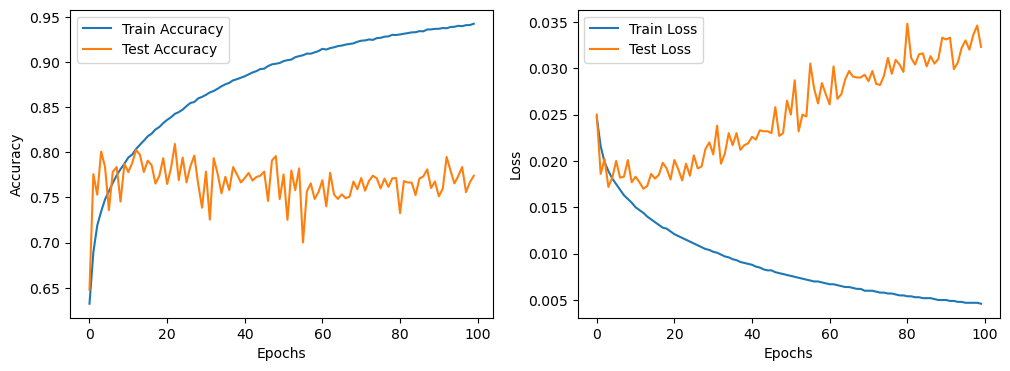

In [2]:
import matplotlib.pyplot as plt

# 정확도와 손실 그래프 그리기
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_ac, label='Train Accuracy')
plt.plot(test_ac, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losse, label='Train Loss')
plt.plot(test_losse, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 이미지 판별

In [4]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 경로
image_path = 'C://Users//User//Desktop//capstone//모델 평가 샘플//car4.jpg'

# 이미지를 불러오고 전처리
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# 이미지 불러오기
image = Image.open(image_path)

# 전처리 적용
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# GPU 사용 가능하면 GPU로 전환 아니면 CPU 사용
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

# 모델 불러오기 및 평가모드로 설정
model_damage = torch.load("C://Users//User//Desktop//capstone//손상//손상 모델//damage_11_24_resnet50.pth")
model_damage.eval()
model_repair = torch.load("C://Users//User//Desktop//capstone//수리방법//수리방법 모델//repair_resnet_11_8.pth")
model_repair.eval()

# 이미지 모델에 전달하고 판별
with torch.no_grad():
    output = model_damage(input_batch)

class_labels = ['파손','찌그러짐','스크레치','이격']
# 판별 결과 해석
_, predicted_class = output.max(1)
print(class_labels[predicted_class.item()])  # 예측된 클래스의 인덱스 출력

# 이미지 모델에 전달하고 판별
with torch.no_grad():
    output = model_repair(input_batch)
    
class_labels = ['도색', '교체', '판금']
# 판별 결과 해석
_, predicted_class = output.max(1)
print(class_labels[predicted_class.item()])  # 예측된 클래스의 인덱스 출력

파손
도색


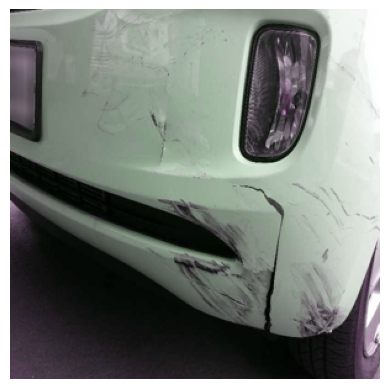

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 열기
image = Image.open(image_path)

# 이미지 크기 조정
new_size = (300, 300)
image = image.resize(new_size)

# 이미지 출력
plt.imshow(image)
plt.axis('off')
plt.show()